In [1]:
import pandas as pd
import plotnine as p9
import numpy as np


In [2]:
p9.theme_set(
    p9.theme(
        plot_background=p9.element_rect(fill='#f0f0f0'),  # Main background
        panel_background=p9.element_rect(fill='#ffffff')  # Axis/Plotting area
    )
)

In [ ]:
# read data
results_df = pd.read_csv("Simulations/results/combined_sim_results.csv")

In [5]:
results_df.head(5)

,idx,model,estimand,gamma_noise,mean,median,true,bias,std,RMSE_rel,MAPE,covering,mean_ind_cover,w_dist
0,241_0_0,true_net,dynamic,2.0,3.64742,3.14657,3.52991,0.11752,0.12624,0.048860,0.036490,True,1.000,0.252993
1,241_0_0,true_net,gate,2.0,12.88285,12.33937,12.46600,0.41685,0.44798,0.049090,0.033150,True,1.000,0.252993
2,241_0_0,obs_net,dynamic,2.0,1.95089,1.26411,3.52991,-1.57901,0.45786,0.465750,0.478550,False,0.220,3.868785
3,241_0_0,obs_net,gate,2.0,6.36634,6.30477,12.46600,-6.09967,1.40691,0.502150,0.473590,False,0.040,3.868785
4,241_0_0,MWG,dynamic,2.0,3.66773,3.49961,3.52991,0.13782,0.18554,0.039288,0.146685,True,0.998,0.574748


In [6]:
results_df["gamma_noise"] = pd.to_numeric(results_df["gamma_noise"], errors="coerce")
results_df["RMSE_rel"] = pd.to_numeric(results_df["RMSE_rel"], errors="coerce")
results_df["MAPE"] = pd.to_numeric(results_df["MAPE"], errors="coerce")

In [7]:
results_df["model"].unique()

array(['true_net', 'obs_net', 'MWG', 'MWG_no_z', 'MWG_rep', 'MWG_misspec',
       'two_stage_refined', 'two_stage_no_refine',
       'two_stage_rep_refined', 'cont_relax'], dtype=object)

In [8]:
# save summary stat across iterations

# Define model order and rename categories
model_rename = {
    "obs_net": "Obs.",
    "cont_relax": "Cont. relax.",
    "two_stage_no_refine": "Two-stage (Cut)",
    "two_stage_refined": "Two-stage (LIP)",
    "two_stage_rep_refined": "Two-stage (LIP; rep)", 
    "MWG_misspec": "BG (misspec)",
    "MWG_no_z": "BG (no Z)",
    "MWG": "BG",
    "MWG_rep": "BG (rep)",
    "true_net": "True",
}


results_df["model"] = results_df["model"].replace(model_rename)
results_df["model"] = pd.Categorical(results_df["model"], categories=model_rename.values(), ordered=True)



summary_df = (
    results_df
    .groupby(["gamma_noise", "model", "estimand"])
    .agg(
        coverage = ("covering", "mean"),

        rmse_rel = ("RMSE_rel","mean"),
        rmse_rel_q025 = ("RMSE_rel",  lambda x: np.percentile(x, 2.5)),
        rmse_rel_q975 = ("RMSE_rel",  lambda x: np.percentile(x, 97.50)),
        rmse_rel_high = ("RMSE_rel", lambda x: np.mean(x) + np.std(x)),
        rmse_rel_low = ("RMSE_rel", lambda x: np.mean(x) - np.std(x)),

        mape = ("MAPE", "mean"),
        mape_q025 = ("MAPE", lambda x: np.percentile(x, 2.5)),
        mape_q975 = ("MAPE", lambda x: np.percentile(x, 97.5)),
        mape_low = ("MAPE", lambda x: np.mean(x) - np.std(x)),
        mape_high = ("MAPE", lambda x: np.mean(x) + np.std(x)),
        )
    .reset_index()
)

def assign_family(model_name):
    if "Two-stage" in model_name:
        return "Two-stage"
    elif "BG" in model_name:
        return "BG"
    else:
        return "Baseline"

summary_df["family"] = summary_df["model"].apply(assign_family)

/var/folders/57/pk6tp2hs4fn90n5yyf8dd0z40000gn/T/ipykernel_2951/1187749560.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


In [9]:
summary_df.head(5)

,gamma_noise,model,estimand,coverage,rmse_rel,rmse_rel_q025,rmse_rel_q975,rmse_rel_high,rmse_rel_low,mape,mape_q025,mape_q975,mape_low,mape_high,family
0,2.0,Obs.,dynamic,0.003333,0.568705,0.358256,0.787707,0.680402,0.457007,0.597973,0.344780,0.863656,0.464898,0.731048,Baseline
1,2.0,Obs.,gate,0.000000,0.585348,0.392985,0.789058,0.687335,0.483360,0.563917,0.360498,0.776450,0.457230,0.670604,Baseline
2,2.0,Cont. relax.,dynamic,0.110000,0.438958,0.045453,0.990789,0.723983,0.153934,0.539173,0.204955,1.118800,0.255845,0.822502,Baseline
3,2.0,Cont. relax.,gate,0.060000,0.433863,0.024833,1.001870,0.725683,0.142042,0.449729,0.109452,1.002420,0.175374,0.724084,Baseline
4,2.0,Two-stage (Cut),dynamic,0.013333,0.590331,0.424909,0.742950,0.683319,0.497343,0.637390,0.444511,0.810296,0.526008,0.748773,Two-stage


/Users/barwein/code/pystat/.venv/lib/python3.13/site-packages/plotnine/scales/scale_shape.py:82: PlotnineWarning: Using shapes for an ordinal variable is not advised.


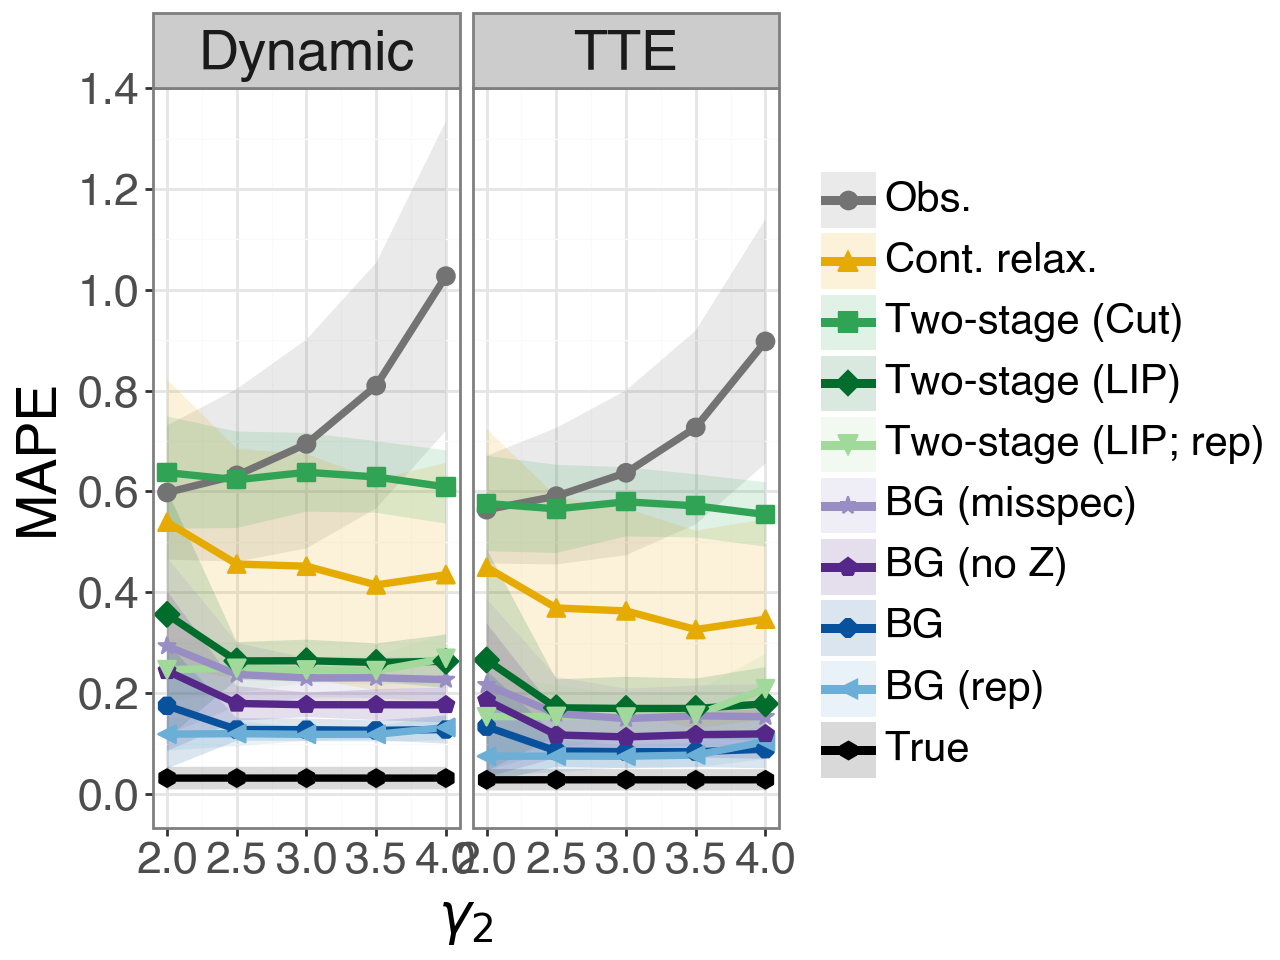

/Users/barwein/code/pystat/.venv/lib/python3.13/site-packages/plotnine/ggplot.py:623: PlotnineWarning: Saving 10 x 7 in image.
/Users/barwein/code/pystat/.venv/lib/python3.13/site-packages/plotnine/ggplot.py:624: PlotnineWarning: Filename: Simulations/results/figs/plot_mape.png
/Users/barwein/code/pystat/.venv/lib/python3.13/site-packages/plotnine/scales/scale_shape.py:82: PlotnineWarning: Using shapes for an ordinal variable is not advised.


In [10]:

# Rename facet titles
# facet_labels = {"dynamic": "Dynamic", "stoch": "Stochastic", "gate": "GATE"}
facet_labels = {"dynamic": "Dynamic", "gate": "TTE"}
summary_df["estimand"] = summary_df["estimand"].replace(facet_labels)


custom_colors = {
    # --- Baselines: Greys/Blacks ---
    "True": "#000000",        # Pure Black
    "Obs.": "#737373",        # Dark Grey
    
    # --- Two-Stage: Greens ---
    "Two-stage (LIP)": "#006d2c",   # Dark Green
    "Two-stage (Cut)": "#31a354", # Medium Green
    "Two-stage (LIP; rep)": "#a1d99b",       # Light Green
    
    # --- BG Family: Blues ---
    "BG": "#08519c",          # Dark Blue
    "BG (rep)": "#6baed6",    # Medium/Light Blue
    
    # --- MWG / Misspecified Family: Purples/Teals ---
    "BG (no Z)": "#542788",       # Dark Purple
    "BG (misspec)": "#998ec3",    # Light Purple
    
    # --- Cont. Relax: Gold ---
    "Cont. relax.": "#E6AB02",     # Gold/Dark Yellow
}

plot_mape = (
    p9.ggplot(summary_df, p9.aes(x="gamma_noise", 
                                 y="mape", 
                                 group="model", 
                                #  color="model",
                                #  fill ="model",
                                 shape="model"
                                 ))
    + p9.geom_ribbon(
        p9.aes(ymin="mape_low", ymax="mape_high", fill ="model"),
        # p9.aes(ymin="mape_q025", ymax="mape_q975", fill ="model"),
        alpha=0.15,
        color=None, 
    )
    + p9.geom_line(p9.aes(color="model"), size=1.5)
    + p9.geom_point(p9.aes(color="model"), size=3)
    + p9.scale_color_manual(values=custom_colors)
    + p9.scale_fill_manual(values=custom_colors)
    + p9.theme_bw()
    # + p9.theme_classic()
    + p9.facet_wrap("estimand", scales="fixed")
    + p9.labs(y="MAPE", x=r'$\gamma_2$', color="", shape="", fill="")
    + p9.scale_x_continuous(breaks=summary_df["gamma_noise"].unique())
    + p9.scale_y_continuous(limits=(0, None), breaks=np.arange(0, 1.6, 0.2))
    + p9.theme(
        plot_background=p9.element_rect(fill='white', color='white'), # Overall plot background

        legend_text=p9.element_text(size=15),
        legend_key_size=20,
        axis_title_x=p9.element_text(size=20,),
        axis_title_y=p9.element_text(size=20,),
        axis_text_x=p9.element_text(size=16),
        axis_text_y=p9.element_text(size=16),
        strip_text=p9.element_text(size=20, weight='bold'),  
        legend_position="right",
    )
)

plot_mape.show()

plot_mape.save("Simulations/results/figs/plot_mape.png",
                dpi=300,
                width=10,
                height=7)

/Users/barwein/code/pystat/.venv/lib/python3.13/site-packages/plotnine/scales/scale_shape.py:82: PlotnineWarning: Using shapes for an ordinal variable is not advised.


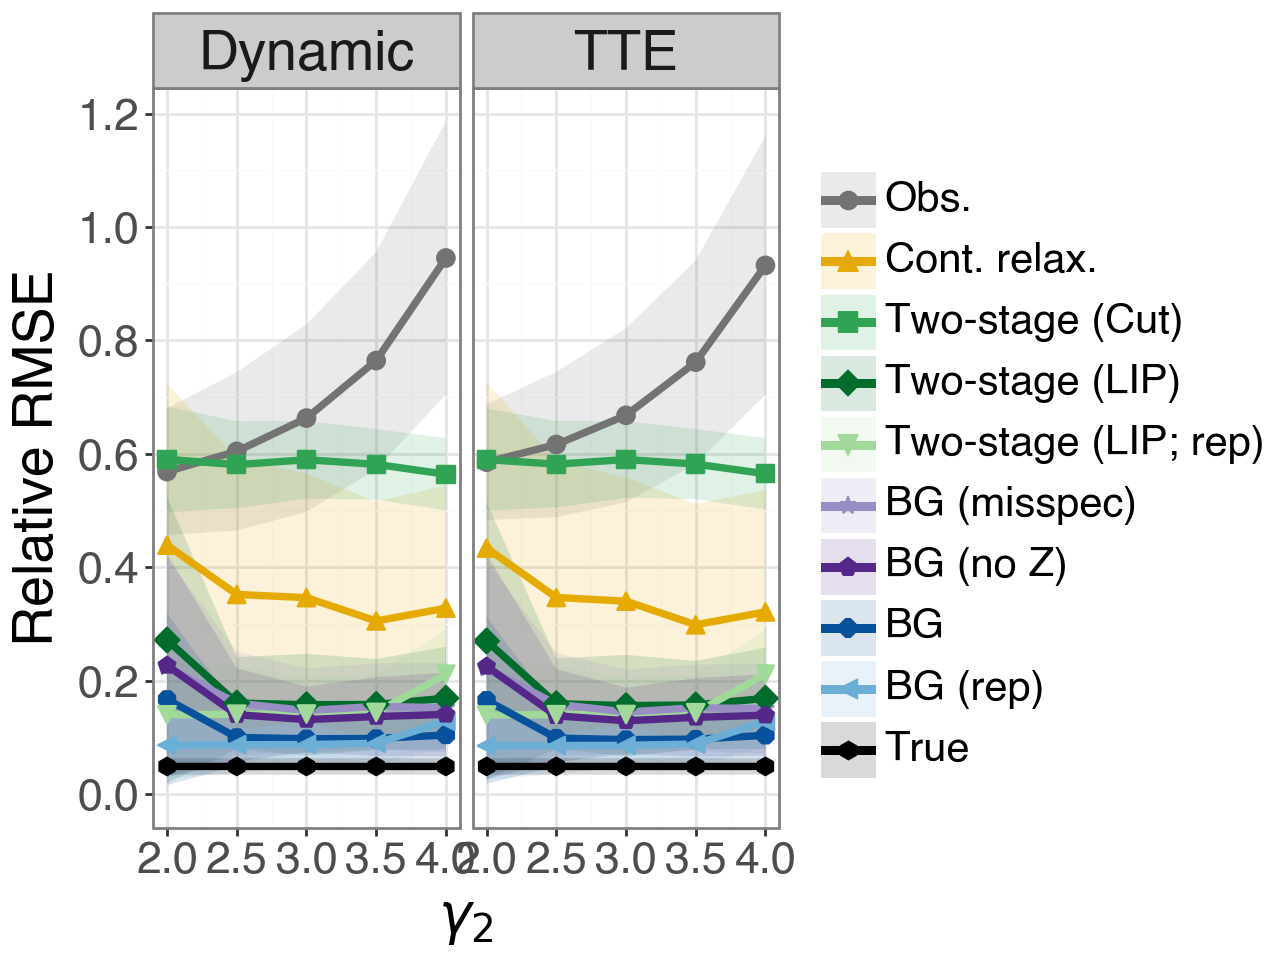

/Users/barwein/code/pystat/.venv/lib/python3.13/site-packages/plotnine/ggplot.py:623: PlotnineWarning: Saving 10 x 7 in image.
/Users/barwein/code/pystat/.venv/lib/python3.13/site-packages/plotnine/ggplot.py:624: PlotnineWarning: Filename: Simulations/results/figs/plot_rrmse.png
/Users/barwein/code/pystat/.venv/lib/python3.13/site-packages/plotnine/scales/scale_shape.py:82: PlotnineWarning: Using shapes for an ordinal variable is not advised.


In [11]:
# Relative RMSE


plot_rrmse = (
    p9.ggplot(summary_df, p9.aes(x="gamma_noise", 
                                 y="rmse_rel", 
                                 group="model", 
                                #  color="model",
                                #  fill ="model",
                                 shape="model"
                                 ))
    + p9.geom_ribbon(
        p9.aes(ymin="rmse_rel_low", ymax="rmse_rel_high", fill ="model"),
        alpha=0.15,
        color=None, 
    )
    + p9.geom_line(p9.aes(color="model"), size=1.5)
    + p9.geom_point(p9.aes(color="model"), size=3)
    + p9.scale_color_manual(values=custom_colors)
    + p9.scale_fill_manual(values=custom_colors)
    + p9.theme_bw()
    # + p9.theme_classic()
    + p9.facet_wrap("estimand", scales="fixed")
    + p9.labs(y="Relative RMSE", x=r'$\gamma_2$', color="", shape="", fill="")
    + p9.scale_x_continuous(breaks=summary_df["gamma_noise"].unique())
    + p9.scale_y_continuous(limits=(0, None), breaks=np.arange(0, 1.6, 0.2))
    + p9.theme(
        plot_background=p9.element_rect(fill='white', color='white'), # Overall plot background
     
        legend_text=p9.element_text(size=15),
        legend_key_size=20,
        axis_title_x=p9.element_text(size=20,),
        axis_title_y=p9.element_text(size=20,),
        axis_text_x=p9.element_text(size=16),
        axis_text_y=p9.element_text(size=16),
        strip_text=p9.element_text(size=20, weight='bold'),  
        legend_position="right",
    )
)

plot_rrmse.show()

plot_rrmse.save("Simulations/results/figs/plot_rrmse.png",
                dpi=300,
                width=10,
                height=7)

/Users/barwein/code/pystat/.venv/lib/python3.13/site-packages/plotnine/scales/scale_shape.py:82: PlotnineWarning: Using shapes for an ordinal variable is not advised.


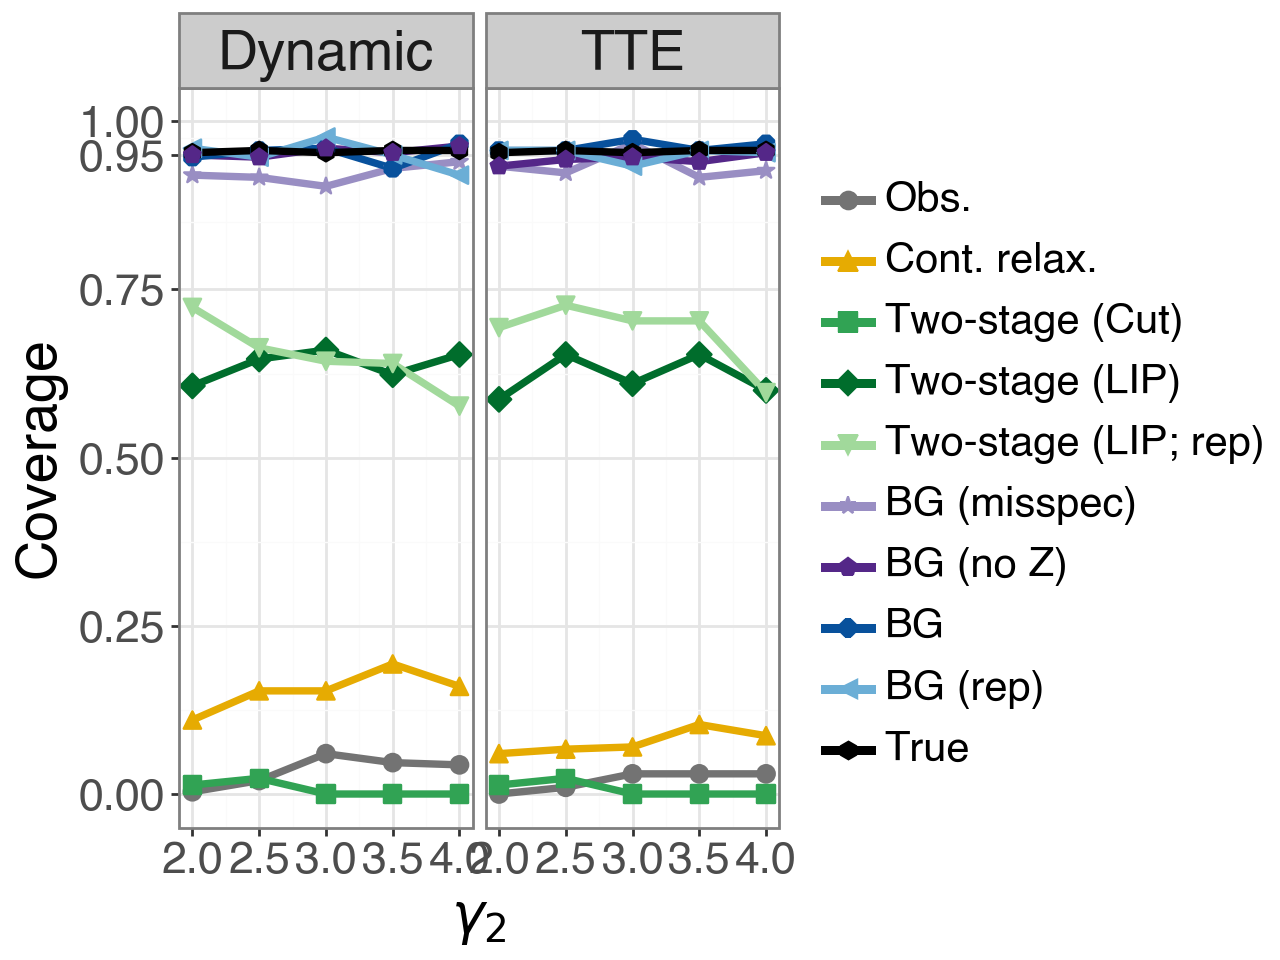

/Users/barwein/code/pystat/.venv/lib/python3.13/site-packages/plotnine/ggplot.py:623: PlotnineWarning: Saving 10 x 7 in image.
/Users/barwein/code/pystat/.venv/lib/python3.13/site-packages/plotnine/ggplot.py:624: PlotnineWarning: Filename: Simulations/results/figs/plot_coverage.png
/Users/barwein/code/pystat/.venv/lib/python3.13/site-packages/plotnine/scales/scale_shape.py:82: PlotnineWarning: Using shapes for an ordinal variable is not advised.


In [12]:
# Coverage plot

plot_coverage = (
    p9.ggplot(summary_df, p9.aes(x="gamma_noise", 
                                 y="coverage", 
                                 group="model", 
                                 color="model",
                                    shape="model"
                                 ))
    + p9.geom_line(p9.aes(color="model"), size=1.5)
    + p9.geom_point(p9.aes(color="model"), size=3)
    + p9.scale_color_manual(values=custom_colors)
    # + p9.geom_hline(yintercept=0.95, linetype="dashed", color="grey", size=1.2, alpha=0.5)
    + p9.scale_y_continuous(limits=(0, 1), breaks=[0.0,0.25,0.5, 0.75, 0.95, 1])
    + p9.theme_bw()
    + p9.facet_wrap("estimand", scales="fixed")

    + p9.labs(y="Coverage", x=r'$\gamma_2$', color="", shape="", fill="")
    + p9.scale_x_continuous(breaks=summary_df["gamma_noise"].unique())
    # + p9.scale_color_manual(values=custom_palette)

    + p9.theme_bw()

    + p9.theme(
        plot_background=p9.element_rect(fill='white', color='white'), # Overall plot background
        # panel_background=p9.element_rect(fill='white', color='white'),# Background of the plotting panels
        # legend_background=p9.element_rect(fill='white', color='white'),# Background of the legend box
        # legend_key=p9.element_rect(fill='white', color='white'),      # Background of individual legend keys

        legend_text=p9.element_text(size=15),
        legend_key_size=20,
        axis_title_x=p9.element_text(size=20,),
        axis_title_y=p9.element_text(size=20,),
        axis_text_x=p9.element_text(size=16),
        axis_text_y=p9.element_text(size=16),
        strip_text=p9.element_text(size=20, weight='bold'),  
        legend_position="right",
    )

)

plot_coverage.show()

plot_coverage.save("Simulations/results/figs/plot_coverage.png",  
                dpi=300,
                width=10,
                height=7)
    